# Introduction

In this notebook we are going to analyze [Titanic Huge Dataset by Kaggle](https://www.kaggle.com/datasets/marcpaulo/titanic-huge-dataset-1m-passengers) and create a model that can predict whether a person well survive or not.

# Importing the libraries

In [19]:
import pandas as pd
import numpy as np
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
import mlflow
import warnings
import os

pp = PrettyPrinter(indent=2)
warnings.simplefilter(action="ignore")

### Setting MLflow Experiment for tracing model's metrics
As the iterative nature of ML project life cycle, using MLflow helps to compare the metrics between different versions of the project and retrieve the best version among them.

In [2]:
mlflow.set_tracking_uri("file:///home/mohammad/mlruns")

mlflow.set_experiment("CodaAlpha_Titanic_Experiment")

<Experiment: artifact_location='file:///home/mohammad/mlruns/318592850117445685', creation_time=1741087710783, experiment_id='318592850117445685', last_update_time=1741087710783, lifecycle_stage='active', name='CodaAlpha_Titanic_Experiment', tags={}>

# Exploratory Data Analysis

Most of the issues appeared as soon as seeing its info and visualizing the correlation heatmap and density, and all the issues are solved in `wrangle` function.

In [3]:
def wrangle(
    filepath:str
) -> pd.DataFrame:
    """
    Reads a CSV file, cleans it, and return it.

    Parameters:
    ----------
    path : str
        The path that contains our CSV file that contains the data needed to process.

    Returns:
    -------
    pd.DataFrame
        A DataFrame contains cleaned data and ready to use.
    """

    # Read CSV file
    df = pd.read_csv(filepath, index_col = "PassengerId")

    # Drop non-important features
    df.drop(columns = [
        "Name", # have too many unique values and no prediction power
        "Cabin", # 77% of its observations are NaN
        "Ticket", # have 681 unique categorical value and no prediction power
        "SibSp" # have a strong correlation with Parch feature
    ], inplace = True)

    # Converting Categorical Features into integer
    df["Sex"] = (df["Sex"] == "male").astype(int)

    # Remove NaN values in Age feature and convert it to integer
    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["Age"] = np.ceil(df["Age"]).astype(int)

    # Remove NaN values in Embarked Feature
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

    # Make sure that there is no NaN in our data
    df.dropna(inplace = True)
    
    return df

In [4]:
df = wrangle("data/huge_1M_titanic.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 1310 to 1001309
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Survived  1000000 non-null  int64  
 1   Pclass    1000000 non-null  int64  
 2   Sex       1000000 non-null  int64  
 3   Age       1000000 non-null  int64  
 4   Parch     1000000 non-null  int64  
 5   Fare      1000000 non-null  float64
 6   Embarked  1000000 non-null  object 
dtypes: float64(1), int64(5), object(1)
memory usage: 61.0+ MB


In [5]:
target = "Survived"
X = df.drop(columns=target)
y = df[target]

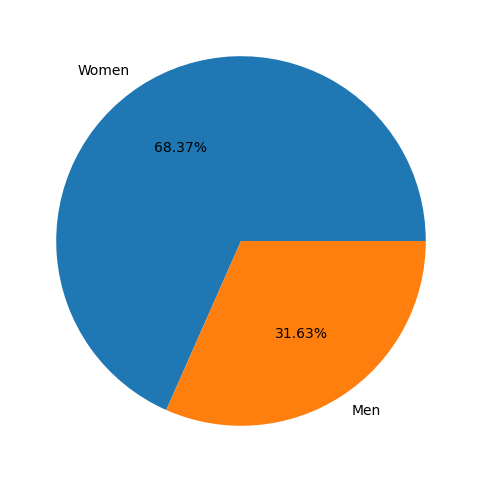

In [38]:
survived_and_gender = df.groupby('Sex')['Survived'].sum().reset_index()

labels = ["Women", "Men"]
values = survived_and_gender['Survived']

plt.figure(figsize = (10, 6))
plt.pie(values, labels = labels, autopct = '%1.2f%%');

## Checking for correlation between numerical features
Checking for multicollinearity in our numerical features using Seaborn's Heatmap

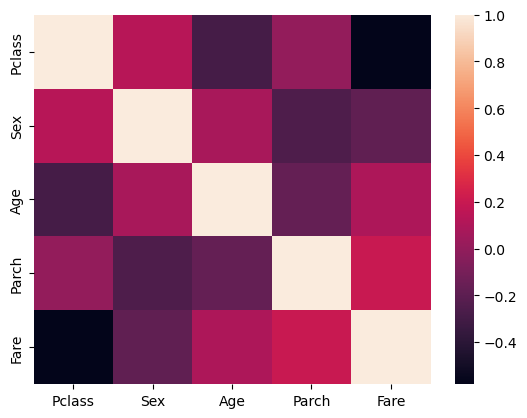

In [29]:
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns=target).corr()
# Plot heatmap of `correlation`
sns.heatmap(correlation);

## Checking the Density of each Feature
A good practice for exploring our data is to check for each feature's distribution using Pandas's Plot function

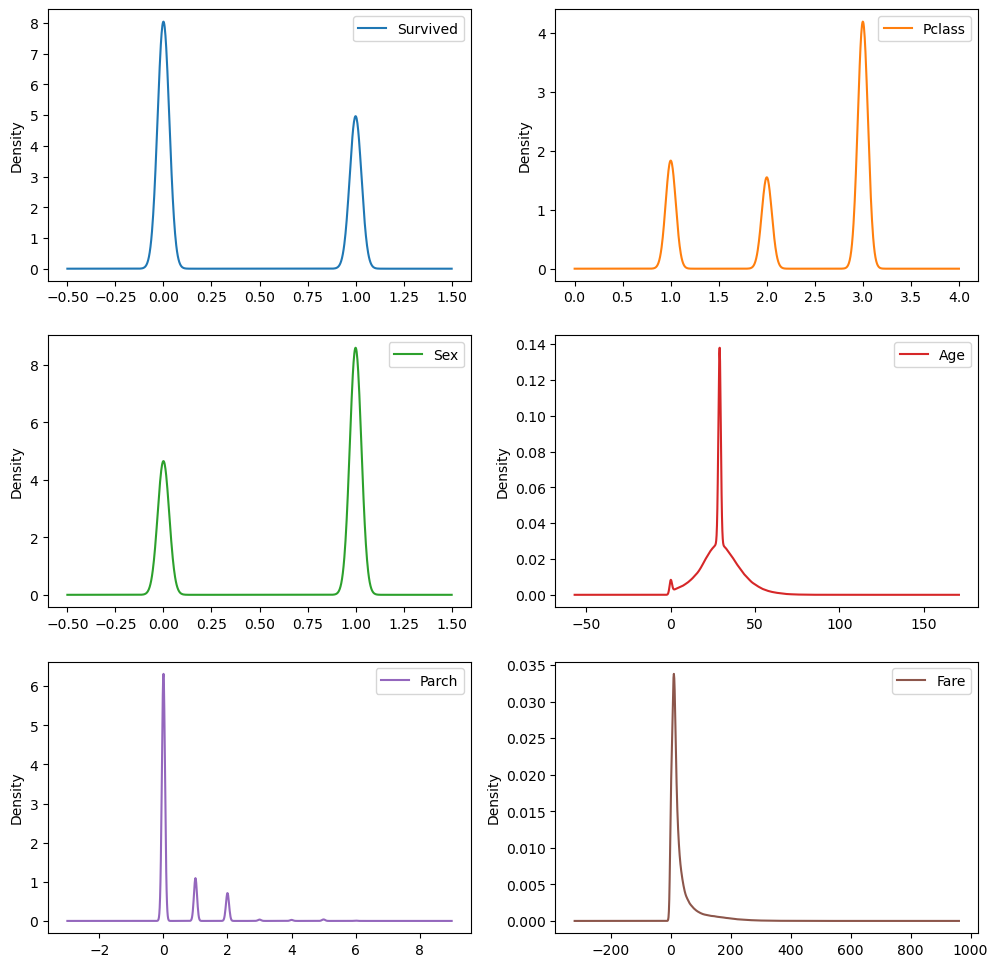

In [35]:
df.plot(kind='density', subplots=True, layout=(3,2), figsize=(12,12), sharex=False);

Even though we have a couple of feature with a huge bias in one of its values as `Parch` and `Fare` for example but it doesn't hurt our model that much.

# Building our Decision Tree Model
First we can start by splitting our data into Training dataset(60%), Validation dataset(20%), and Testing dataset(20%)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = .2, random_state = 42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size = .2, random_state = 42
)

Then we can calculate our baseline by predicting only the majority class in each observation

In [8]:
acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.62


Then before actually building our `pipeline` we need to convert the categorical features we have and for that I used `OrdinalEncoder` as Decision trees split features based on numerical comparisons.

In [9]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Define preprocessing: Only OneHotEncode categorical features, keep others as is
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_cols) #handle_unknown="ignore"
    ],
    remainder="passthrough"  # Leaves numerical features unchanged
)

## Searching for the best Parameters
Using `RandomizedSearchCV` to find the best set of parameters that return the highest f1-score when fitting on our training data

In [ ]:
f1_scorer = make_scorer(f1_score, average='weighted')

testmodel = make_pipeline(
    preprocessor,
    DecisionTreeClassifier()
)

param_distributions = {
    'decisiontreeclassifier__criterion': ["gini", "entropy", "log_loss"],
    'decisiontreeclassifier__max_depth': range(1, 26, 2),
    'decisiontreeclassifier__min_samples_split': [2, 4, 6, 8],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 3, 4],
    'decisiontreeclassifier__max_features': [None, "log2", "sqrt"],
    }

random_search = RandomizedSearchCV(
    estimator = testmodel,
    param_distributions=param_distributions,
    n_iter=25,
    scoring = f1_scorer,
    cv=5,
    n_jobs=-1,
    random_state=42,
    return_train_score=True  # Enables tracking train scores
)
random_search.fit(X_train, y_train)

# Extract best parameters
best_params = random_search.best_params_

# Get training and validation scores
train_score = random_search.cv_results_["mean_train_score"][random_search.best_index_]
val_score = random_search.cv_results_["mean_test_score"][random_search.best_index_]


# Check for overfitting
if train_score - val_score > 0.05:  # Overfitting threshold
    print("Warning: Potential overfitting detected!")
    print(f"Training Score: {train_score:.4f} | Validation Score: {val_score:.4f}")
    
    # Adjust hyperparameters to reduce overfitting
    if 'decisiontreeclassifier__max_depth' in best_params:
        best_params['decisiontreeclassifier__max_depth'] = max(3, best_params['decisiontreeclassifier__max_depth'] - 5)
    if 'decisiontreeclassifier__min_samples_leaf' in best_params:
        best_params['decisiontreeclassifier__min_samples_leaf'] = min(4, best_params['decisiontreeclassifier__min_samples_leaf'] + 1)
    if 'decisiontreeclassifier__min_samples_split' in best_params:
        best_params['decisiontreeclassifier__min_samples_split'] = min(8, best_params['decisiontreeclassifier__min_samples_split'] + 2)

    print(f"Adjusted Hyperparameters: {best_params}")

# Print final results
print(f'Best Parameters: {best_params}')
print(f'Best Validation Score: {val_score:.4f}')

Checking for `max_depth` feature and visualize the training, and validation accuracy at each possiblity

In [10]:
depth_hyperparams = range(1, 26, 2)

# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        preprocessor,
        DecisionTreeClassifier(
        min_samples_split = 8,
        min_samples_leaf = 2,
        max_features = None,
        max_depth = d,
        random_state = 42)
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.7888921875, 0.816215625, 0.828715625]
Validation Accuracy Scores: [0.78974375, 0.81766875, 0.82955625]


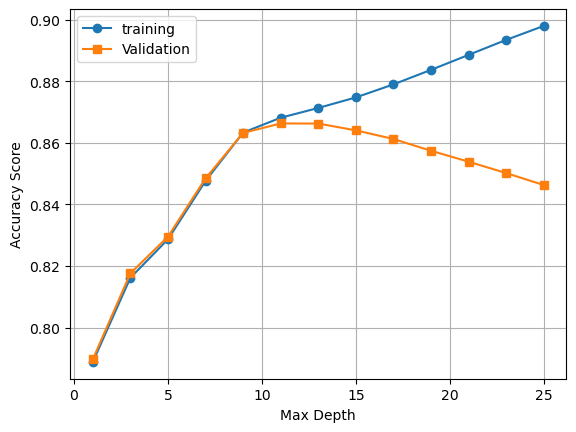

In [11]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, marker='o', label = "training")
plt.plot(depth_hyperparams, validation_acc, marker='s', label = "Validation")
# plt.xticks(depth_hyperparams)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.grid(True)
plt.legend();

## Building our Pipeline

In [13]:
model = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(
        min_samples_split = 8,
        min_samples_leaf = 2,
        max_features = None,
        max_depth = 11,
        random_state = 42)
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Embarked'], dtype='object'))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=11, min_samples_leaf=2,
                                        min_samples_split=8,
                                        random_state=42))])

In [14]:
model.named_steps["decisiontreeclassifier"].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 11,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

# Evaluating our model

After fitting our model to training data we can check it's training, and validation accuracy, and it's classification report.

In [15]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = accuracy_score(y_val, model.predict(X_val))
report = classification_report(y_val, model.predict(X_val), output_dict=True)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.87
Validation Accuracy: 0.87


## Plotting the Decision Tree

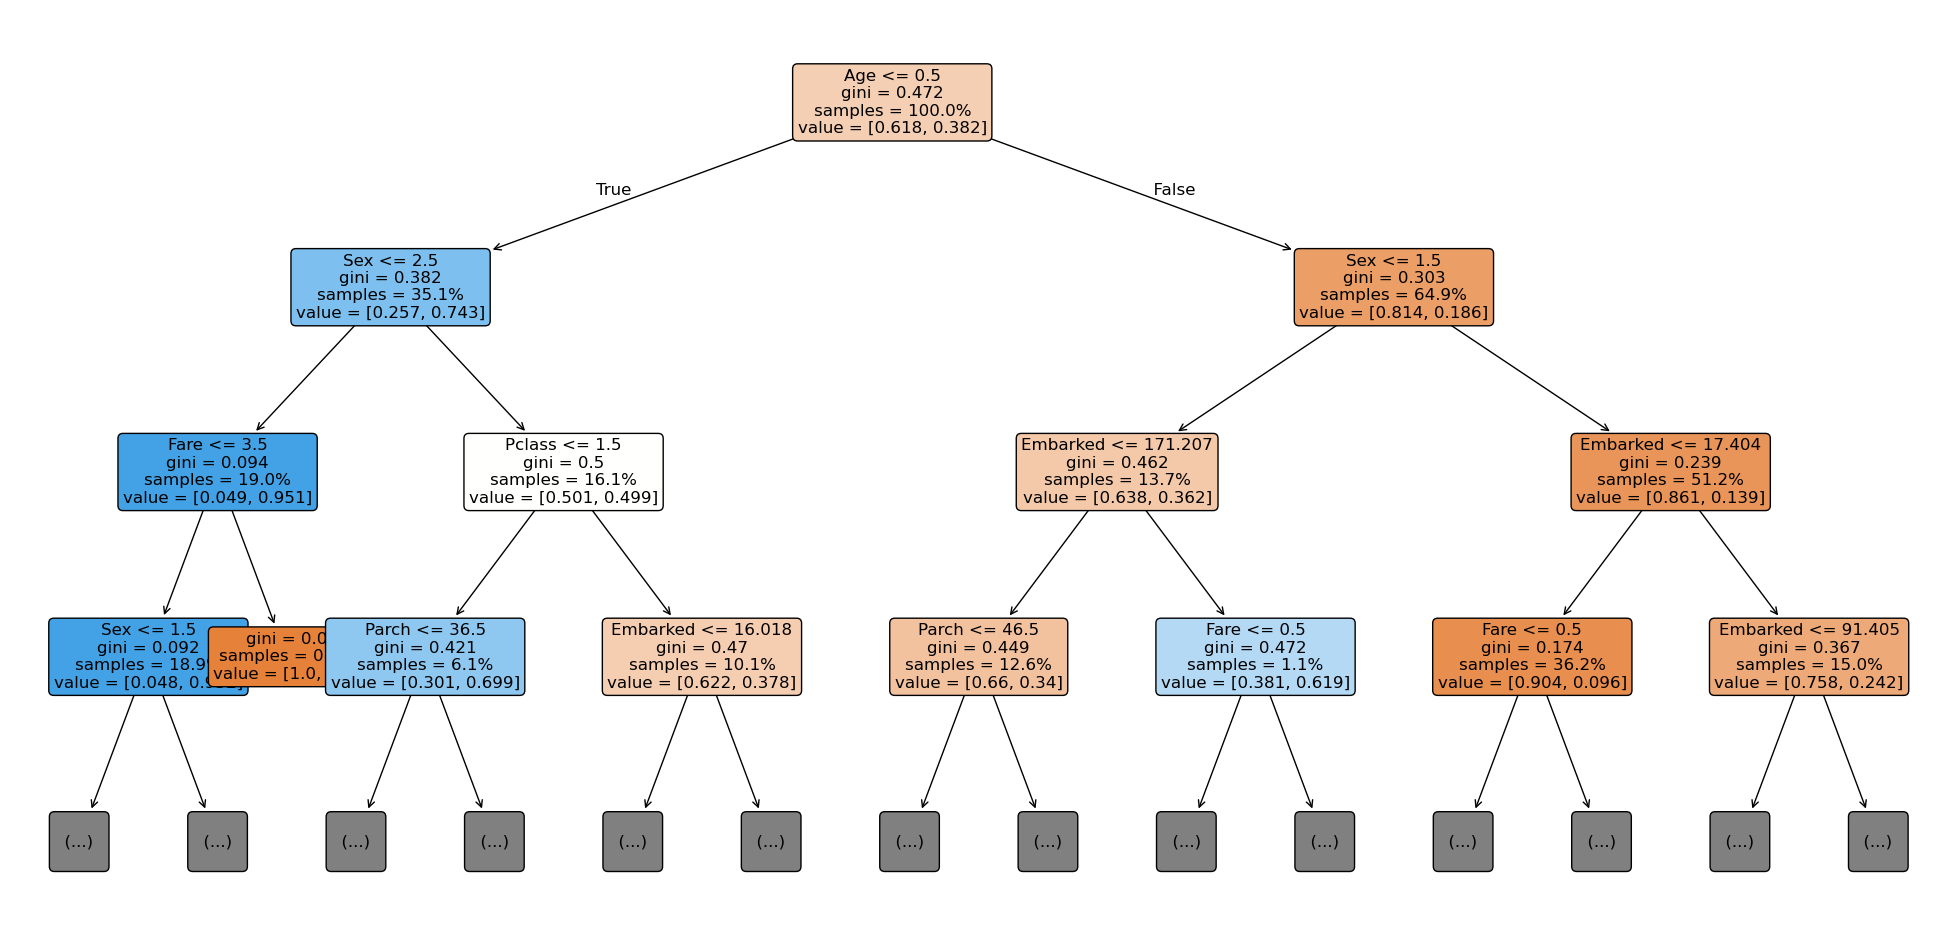

In [16]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeclassifier"],
    feature_names=X_train.columns.to_list(),
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

## Logging the run for experimenting

In [17]:
# Start an MLflow run
with mlflow.start_run(run_name = "Best RandomForest") as run:
    
    # Log model and Params
    mlflow.sklearn.log_model(model, "Dicision Tree")
    mlflow.log_params(model.named_steps["decisiontreeclassifier"].get_params())

    # Log model metrics
    mlflow.log_metric("Training Accuracy", acc_train)
    mlflow.log_metric("Validation Accuracy", acc_val)
    mlflow.log_metric("f1-accuracy", report["accuracy"])

    # Log precision, recall, f1-score per class
    for label, metrics in report.items():
        if isinstance(metrics, dict):  # Ensure it's a class label and not 'accuracy'
            mlflow.log_metric(f"precision_{label}", metrics["precision"])
            mlflow.log_metric(f"recall_{label}", metrics["recall"])
            mlflow.log_metric(f"f1-score_{label}", metrics["f1-score"])
    
    # Plot a graph and save it as an Artifact
    features = X_train.columns
    importances = model.named_steps["decisiontreeclassifier"].feature_importances_

    feat_imp = pd.Series(importances, index=features).sort_values()
    feat_imp.head()

    # Create horizontal bar chart
    feat_imp.plot(kind="barh")
    plt.xlabel("Gini Importance")
    plt.ylabel("Feature")
    plt.title("Decision Tree Feature Importance");
    ax = plt.gca()
    title = ax.get_title()
    temp_name = title + ".png"
    try:
	    plt.savefig(temp_name)
	    mlflow.log_artifact(temp_name)
    finally:
        plt.close()
        os.remove(temp_name)

## Checking the test Accuracy at the end!

In [25]:
report_test = classification_report(y_test, model.predict(X_test), output_dict=True)

print("Testing Report: \n")
pp.pprint(report_test)

Testing Report: 

{ '0': { 'f1-score': 0.8951132300357568,
         'precision': 0.8646669726910834,
         'recall': 0.9277818598754916,
         'support': 123847.0},
  '1': { 'f1-score': 0.8120419359792275,
         'precision': 0.8667322277353121,
         'recall': 0.763843840689139,
         'support': 76153.0},
  'accuracy': 0.86536,
  'macro avg': { 'f1-score': 0.8535775830074921,
                 'precision': 0.8656996002131978,
                 'recall': 0.8458128502823152,
                 'support': 200000.0},
  'weighted avg': { 'f1-score': 0.8634825887543225,
                    'precision': 0.8654533495279992,
                    'recall': 0.86536,
                    'support': 200000.0}}
